# Автокорректор ошибок на Python

На основе блокнота Питера Норвига, Google

In [1]:
%pylab inline
import re
import math
from collections import Counter
import requests

Populating the interactive namespace from numpy and matplotlib


Получим "модель" грамматически правильного текста

In [3]:
TEXT = requests.get('http://norvig.com/big.txt').text
len(TEXT)

6488666

Теперь нужно разбить текст на слова (aka токены). Сосредоточимся только на словах, состоящих из букв. 

In [4]:
def tokens(text):
    """Возвращает список токенов (подряд идущих буквенных последовательностей) в тексте.
    Также приводим текст к нижнему регистру"""
    return re.findall(r'[a-z]+', text.lower())

In [5]:
tokens('This is: A test, 1 , 2, 3. this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [7]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

In [8]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


Сейчас слова появляются в списке в том порядке, как они располагались в тексте.

## Model: Bag of Words

Можем использовать _TEXT_ (список) в качестве *порождающей модели* (generative model) текста. Мы создаём всё же упрощённую модель языка, которая ухватывает часть её сложной структуры. В модели Bag if Words игнорируется порядок слов, но соблюдается частота (представить мешок из игры Лото). Почти наверное полученное предложение из мешка будет грамматически некорректным, но слова в этом предложении будут в +- правильной пропорции (более частные будут встречаться чаще, более редкие - реже). 
Напишем функцию, которая сэмплирует предложение из n слов с помощью данной модели.

In [11]:
def sample(bag, n=10):
    """Сэмплируем случайную последовательность из n слов из модели, описанной нашим мешком слов."""
    return ' '.join(random.choice(bag) for _ in range(n))

In [12]:
sample(WORDS)

'something gap into of an thrust he constitutions sight a'

Другое представление мешка слов - Counter. Он содержит в себе ка качестве value кол-во вхождений слова.

In [13]:
Counter(tokens('Is this a test? It is a test'))

Counter({'is': 2, 'this': 1, 'a': 2, 'test': 2, 'it': 1})

In [14]:
COUNTS = Counter(WORDS)
print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [16]:
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


В 1935 году лингвист Джордж Ципф отметил, что в любом большом тексте n-ое наиболее часто встречающееся слово появляется с частотой - 1/n от частоты наиболее часто встречающегося слова. Это наблюдение получило название _Закона Ципфа_, несмотря на то, что Феликс Ауэрбах заметил это ещё в 1913 году. Если нарисовать частоты слов, начиная от самого часто встречающегося, на log-log-графике, они должны приблизительно следовать прямой линии, если закон Ципфа верен.

In [17]:
len(COUNTS)

29157

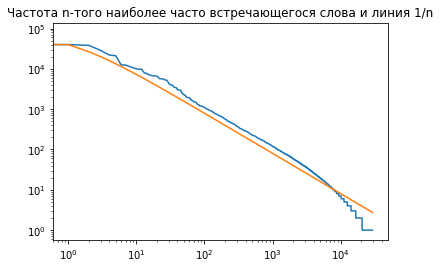

In [19]:
M = COUNTS['the']
yscale('log')
xscale('log')
title('Частота n-того наиболее часто встречающегося слова и линия 1/n')
plot([c for (w, c) in COUNTS.most_common()])
plot([M / i for i in range(1, len(COUNTS))])

## Проверка правописания

**Подход**: найти все кандидаты _c = correct(w)_, достаточно близкие к *w*. Выбрать наиболее вероятный из них.

Применим наивный подход: всегда будем брать более близкое слово, если проверки на близость недостаточно, берём слово с максимальной частотой из WORDS. Сейчас измерим близость с помощью расстояния Леверштейна: минимального необходимого количества удалений, перестановок, вставок и замен символов, необходимых, чтобы одно слово превратилось в другое. 

In [20]:
def correct(word):
    """Поиск лучшего исправления ошибки для слова"""
    candidates = (known(edits0(word)) or
                 known(edits1(word)) or
                 known(edits2(word)) or
                 [word])
    return max(candidates, key=COUNTS.get)

In [22]:
def known(words):
    """Вернуть множество слов, которые есть в нашем словаре"""
    return {w for w in words if w in COUNTS}

def edits0(word):
    """Вернуть все строки, которые находятся на edit_distance == 0 от word"""
    return {word}

def edits2(word):
    """Вернуть все строки, которые находятся на edit_distance == 1 от word"""
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [24]:
from string import ascii_lowercase as alphabet

def edits1(word):
    """Возвращает список всех строк на расстоянии edit_distance == 1 от word"""
    pairs = splits(word)
    deletes = [a + b[1:]                     for (a, b) in pairs if b]
    transposes = [a + b[1:] + b[0] + b[2:]   for (a, b) in pairs if len(b) > 1]
    replaces = [a + c + b[1:]                for (a, b) in pairs 
                                                 for c in alphabet if b]
    inserts = [a + c + b                     for (a, b) in pairs 
                                                 for c in alphabet]
    
    return set(deletes + transposes + replaces + inserts)
    
def splits(word):
    """Возвращает список всех возможных разбиений слова на пару (a, b)"""
    return [(word[:i], word[i:]) for i in range(len(word) + 1)]

In [25]:
splits('wirds')

[('', 'wirds'),
 ('w', 'irds'),
 ('wi', 'rds'),
 ('wir', 'ds'),
 ('wird', 's'),
 ('wirds', '')]

In [26]:
print(edits0('wird'))

{'wird'}


In [27]:
print(edits1('wird'))

{'wire', 'vird', 'wirkd', 'wixd', 'wtird', 'wirdu', 'cwird', 'wfird', 'wcrd', 'wiwrd', 'wiwd', 'wirq', 'bwird', 'wird', 'lird', 'wirdw', 'wcird', 'xird', 'vwird', 'wdird', 'wijrd', 'wuird', 'wwird', 'wibrd', 'wirdg', 'qird', 'wirdy', 'wdrd', 'widd', 'wnrd', 'wirdv', 'wbird', 'wmrd', 'weird', 'whrd', 'wirds', 'hwird', 'wirx', 'wmird', 'wiro', 'wirj', 'widrd', 'wimrd', 'wirb', 'wivrd', 'wixrd', 'wirtd', 'wirxd', 'wirid', 'wiry', 'wifrd', 'wrird', 'oird', 'wirdt', 'wirdc', 'wfrd', 'wikrd', 'wiru', 'wrrd', 'wiurd', 'wicd', 'cird', 'dird', 'wivd', 'wigrd', 'wirv', 'lwird', 'wirk', 'wirde', 'wirz', 'wirsd', 'twird', 'owird', 'mird', 'wiod', 'wirf', 'kird', 'wirjd', 'wirgd', 'wid', 'wqird', 'wirdn', 'wirh', 'winrd', 'wirpd', 'wiad', 'wijd', 'rird', 'swird', 'wisrd', 'wizrd', 'ewird', 'zwird', 'werd', 'dwird', 'wlrd', 'wirnd', 'wirud', 'ywird', 'wgird', 'wirhd', 'wjird', 'wiord', 'wirdf', 'wirrd', 'hird', 'word', 'iwird', 'wirr', 'wirdj', 'wiryd', 'wkird', 'irdwrd', 'wiyrd', 'wiqd', 'wild', 'w

In [28]:
print(len(edits2('wird')))

24953
